In [1]:
import numpy as np
import sys,os
from glob import glob
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from skimage.draw import polygon
from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity

%matplotlib inline

In [2]:
BUCKETCOLORS = [
    (44/255., 105/255., 154/255., 0.5),
    (13/255., 179/255., 158/255., 0.5),
    (239/255., 234/255.,  90/255., 0.5),
    (241/255., 196/255.,  83/255., 0.5),
    (22/255., 219/255., 147/255., 0.5),
    (22/255., 219/255., 147/255., 0.5),
    (242/255., 158/255.,  76/255., 0.5),
    (44/255., 105/255., 154/255., 0.5),
    (4/255., 139/255., 168/255., 0.5),
    (131/255., 227/255., 119/255., 0.5),
    (84/255.,  71/255., 140/255., 0.5),
    (241/255., 196/255.,  83/255., 0.5),
    (185/255., 231/255., 105/255., 0.5),
    (185/255., 231/255., 105/255., 0.5),
    (128/255., 128/255., 128/255., 0.5)
]


class BBox:
    name = ''
    coords = None
    id = -1
    durations = None

    def __init__(self, name, coords, id):
        self.name = name
        self.coords = coords
        self.id = id


def get_gt_elements(
    imname,
    eledir,
    simple=False
):
    elementLabel = pd.read_csv(os.path.join(eledir, imname), names=[
                               'bboxID', 'category', 'x', 'y'])
    elementCoords = []
    elementX = []
    elementY = []
    tmp = 0
    curName = ""

    boxes = []

    for row in elementLabel.iterrows():
        # row[1][0]: id
        # row[1][1]: category name
        # row[1][2]: x
        # row[1][3]: y

        # a new bbox
        if int(row[1][0]) > tmp:
            # Store the last bbox
            if tmp > 0:
                if (simple):
                    boxid = get_bboxid_by_name_9(curName)
                else:
                    boxid = get_bboxid_by_name(curName)
                box = BBox(curName, elementCoords[-1], boxid)
                boxes.append(box)
            tmp = int(row[1][0])
            curName = row[1][1].strip()

            elementCoords.append([])
            elementX.append([])
            elementY.append([])

        elementCoords[-1].append([int(row[1][2]), int(row[1][3])])
        if(curName != 'data'):
            elementX[-1].append(int(row[1][2]))
            elementY[-1].append(int(row[1][3]))

    boxid = get_bboxid_by_name(curName)
    box = BBox(curName, elementCoords[-1], boxid)
    boxes.append(box)
    return elementCoords, elementX, elementY, boxes


SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

MARKERS = ['s', 'P', '*', 'X', 'p', 'v']
LINESTYLES = ['dotted', 'dashed', 'dashdot', '-', '--', '-.', ':', 'solid']

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



def get_bboxid_by_name(name):
    id1 = -1
    if 'annotation' in name:
        id1 = 0
    elif 'axis' in name:
        id1 = 1
    elif 'graphical element' in name:
        id1 = 2
    elif 'legend' in name:
        id1 = 3
    elif 'object' in name:
        if 'photograph' in name:
            id1 = 4
        else:  # 'pictogram'
            id1 = 5
    elif 'text' in name:
        if '(title)' in name:
            id1 = 6
        elif '(header row)' in name:
            id1 = 7
        elif '(label)' in name:
            id1 = 8
        elif '(paragraph)' in name:
            id1 = 9
        else:
            id1 = 10
    elif 'data (' in name:
        id1 = 11
    elif name == 'data':
        id1 = 12
    else:
        id1 = 13
    return id1


def get_bboxid_by_name_9(name):
    id1 = -1
    if 'annotation' in name:
        id1 = 0
    elif 'axis' in name:
        id1 = 1
    elif 'graphical element' in name:
        id1 = 2
    elif 'legend' in name:
        id1 = 3
    elif 'object' in name:
        id1 = 4
    elif 'text' in name:
        if ('(title)' in name
                or '(header row)' in name
                or '(paragraph)' in name):
            id1 = 5
        else:
            id1 = 6
    elif 'data' in name:
        id1 = 7
    else:
        id1 = 8
    return id1

def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)


# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
print(data.grid_size)
species_names = ["Bradypus Variegatus", "Microryzomys Minutus"]

Xtrain = np.vstack([data["train"]["dd lat"], data["train"]["dd long"]]).T
ytrain = np.array(
    [d.decode("ascii").startswith("micro") for d in data["train"]["species"]],
    dtype="int",
)
Xtrain *= np.pi / 180.0  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
print(xgrid.shape)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
print(X.shape, Y.shape)
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()


xy = np.vstack([Y.ravel(), X.ravel()]).T
print(xy.shape)

xy = xy[land_mask]
xy *= np.pi / 180.0


0.05
(1212,)
(319, 243) (319, 243)
(77517, 2)


 - computing KDE in spherical coordinates
77517
(319, 243) (319, 243)
 - computing KDE in spherical coordinates
77517
(319, 243) (319, 243)


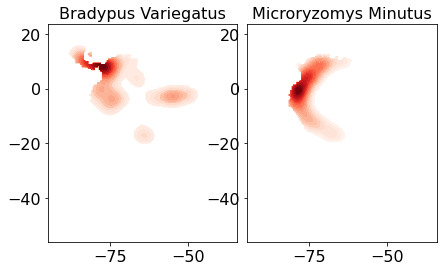

In [3]:

# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(
        bandwidth=0.04, metric="haversine", kernel="gaussian", algorithm="ball_tree"
    )
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], 0, dtype="int")
    print(land_mask.shape[0])
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(1, Z.max(), 25)
    print(np.shape(X), np.shape(Y) )
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    plt.title(species_names[i])

plt.show()